# Projeto Criando um Sistema de Recomendação por Imagens Digitais

In [1]:
# Mostrar a pasta local
!pwd

/teamspace/studios/this_studio


In [2]:
# Escrever arquivo com usuário e senha após cadastro no kaggle
# substitua usuario e senha por suas credenciais

#f = open("kaggle.json", "a")
#f.write('{"username":"usuario","key":"senha"}')
#f.close()

In [1]:
# Instalando o kaggle
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.6.6-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.6
    Uninstalling kaggle-1.6.6:
      Successfully uninstalled kaggle-1.6.6


In [ ]:
#Configurando
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Baixando e preparando os dados de produtos de moda

In [4]:
# Baixando o banco de dados de imagens de produtos de moda
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

100%|████████████████████████████████████████▉| 564M/565M [00:04<00:00, 175MB/s]
100%|█████████████████████████████████████████| 565M/565M [00:04<00:00, 134MB/s]


In [ ]:
# Extraindo os arquivos
!unzip -n fashion-product-images-small.zip

Archive:  fashion-product-images-small.zip
  inflating: images/10000.jpg        
  inflating: images/10001.jpg        
  inflating: images/10002.jpg        
  inflating: images/10003.jpg        
  inflating: images/10004.jpg        
  inflating: images/10005.jpg        
  inflating: images/10006.jpg        
  inflating: images/10007.jpg        
  inflating: images/10008.jpg        
  inflating: images/10009.jpg        
  inflating: images/10010.jpg        
  inflating: images/10011.jpg        
  inflating: images/10012.jpg        
  inflating: images/10013.jpg        
  inflating: images/10014.jpg        
  inflating: images/10015.jpg        
  inflating: images/10016.jpg        
  inflating: images/10017.jpg        
  inflating: images/10018.jpg        
  inflating: images/10019.jpg        
  inflating: images/10020.jpg        
  inflating: images/10021.jpg        
  inflating: images/10022.jpg        
  inflating: images/10023.jpg        
  inflating: images/10024.jpg        
  infla

In [1]:
# Preparando os arquivos

In [1]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

In [ ]:
os.mkdir('Fashion_data')

In [3]:
os.chdir('Fashion_data')

In [5]:
!pwd

/teamspace/studios/this_studio/Fashion_data


In [2]:
df = pd.read_csv('/teamspace/studios/this_studio/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/teamspace/studios/this_studio/images')
co = 0
os.mkdir('/teamspace/studios/this_studio/Fashion_data/categories')

FileExistsError: [Errno 17] File exists: '/teamspace/studios/this_studio/Fashion_data/categories'

In [8]:
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/teamspace/studios/this_studio/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/teamspace/studios/this_studio/Fashion_data/categories', category))
    path_from = os.path.join('/teamspace/studios/this_studio/images', image)
    path_to = os.path.join('/teamspace/studios/this_studio/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:01<00:00, 245.42it/s]

Moved 44441 images.


## Encoder Fine-tuning

In [6]:
# Tive que fazer downgrade da versão do tensorflow 2.16 para 2.15 
#!pip install tensorflow==2.15.0 tensorflow_hub==0.16.1

  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorb

Download the pre-trained image model and add two additional layers on top of that: the first layer is a feature vector layer and the second layer is the classification layer. We will only train these 2 layers on our data and after training, we will select the feature vector layer as the output of our fine-tuned encoder. After fine-tuning the model, we will save the feature extractor for later use.

In [3]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-03-12 20:43:22.607799: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 20:43:22.754780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 20:43:22.754976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 20:43:22.774941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 20:43:22.829261: I tensorflow/core/platform/cpu_feature_guar

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


2024-03-12 20:43:25.068844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 20:43:25.246925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 20:43:25.247170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [5]:
data_dir = '/teamspace/studios/this_studio/Fashion_data/categories'

In [6]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [7]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1


2024-03-12 20:43:56.107046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 20:43:56.107320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 20:43:56.107464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212748999 (811.57 MB)
Trainable params: 1574919 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_________________________________________________________________


In [8]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

2024-03-12 20:44:16.218232: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


2024-03-12 20:44:40.265072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-12 20:44:40.460934: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-12 20:44:57.041665: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc2ecbb4d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 20:44:57.041725: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1710276297.140173   23667 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1111/1111 [==============================] - 1165s 1s/step - loss: 0.2506 - accuracy: 0.9681 - val_loss: 0.1348 - val_accuracy: 0.9888
Epoch 2/5
1111/1111 [==============================] - 1137s 1s/step - loss: 0.1807 - accuracy: 0.9771 - val_loss: 0.1347 - val_accuracy: 0.9888
Epoch 3/5
1111/1111 [==============================] - 1137s 1s/step - loss: 0.1859 - accuracy: 0.9762 - val_loss: 0.1347 - val_accuracy: 0.9888
Epoch 4/5
1111/1111 [==============================] - 1136s 1s/step - loss: 0.1861 - accuracy: 0.9771 - val_loss: 0.1347 - val_accuracy: 0.9888
Epoch 5/5
1111/1111 [==============================] - 1136s 1s/step - loss: 0.1771 - accuracy: 0.9778 - val_loss: 0.1346 - val_accuracy: 0.9888


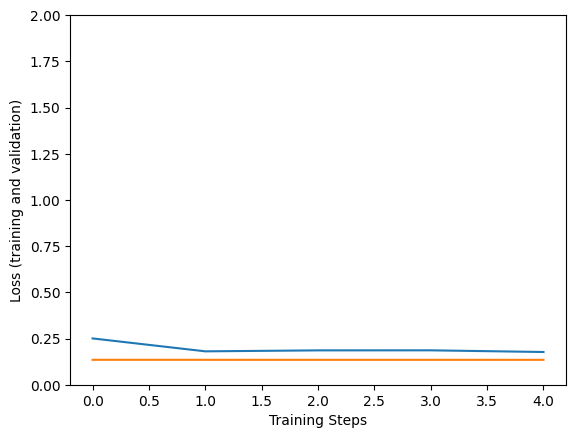

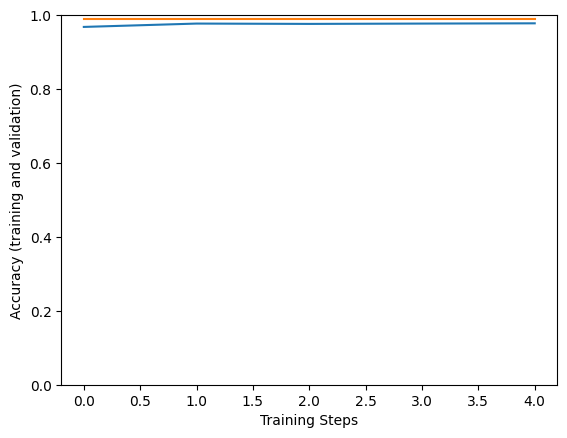

In [10]:

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [11]:
if not os.path.exists('/teamspace/studios/this_studio/ImgSim/'):
    os.mkdir('/teamspace/studios/this_studio/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/teamspace/studios/this_studio/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/teamspace/studios/this_studio/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /teamspace/studios/this_studio/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /teamspace/studios/this_studio/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /teamspace/studios/this_studio/ImgSim/bit_model/assets


INFO:tensorflow:Assets written to: /teamspace/studios/this_studio/ImgSim/bit_model/assets


# Image vectorization

Now, we will use the encoder to encode the images. We will save feature vector of each image as an array in a directory. After processing, we will save these embeddings for later use.

In [12]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [13]:
img_paths = []
for path in Path('/teamspace/studios/this_studio/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [14]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [15]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/teamspace/studios/this_studio/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

2024-03-12 22:21:20.169159: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 're_lu_48/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2024-03-12 22:21:20.169218: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


In [16]:
imgvec_path = '/teamspace/studios/this_studio/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [17]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [08:32<00:00,  9.76it/s]


# Metadata and indexing

We will assign a unique id to each image and create dictionaries to locate information of this image: 1) Image id to Image name dictionary, 2) Image id to image feature vector dictionary, and 3) (optional) Image id to metadata product id dictionary. We will also create an image id to image feature vector indexing. Then we will save these dictionaries and index object for later use.

In [18]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

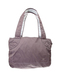

In [19]:
test_img = '/teamspace/studios/this_studio/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [23]:
root_path = '/teamspace/studios/this_studio/ImgSim'

In [24]:
styles = pd.read_csv('/teamspace/studios/this_studio/styles.csv', on_bad_lines='warn')
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles.csv', index=False)

Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 fields, saw 11
Skipping line 37770: expected 10 fields, saw 11
Skipping line 38105: expected 10 fields, saw 11
Skipping line 38275: expected 10 fields, saw 

In [25]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [26]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/teamspace/studios/this_studio/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [27]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:20, 249.94it/s]


In [28]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [29]:
file_path = '/teamspace/studios/this_studio/ImgSim/'

In [30]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

# Local testing

In [31]:
from PIL import Image
import matplotlib.image as mpimg

### Testando com imagens baixadas da internet 

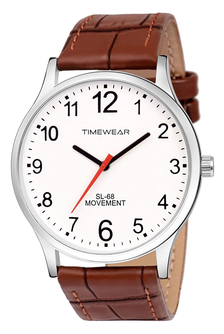

In [33]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.LANCZOS)
img

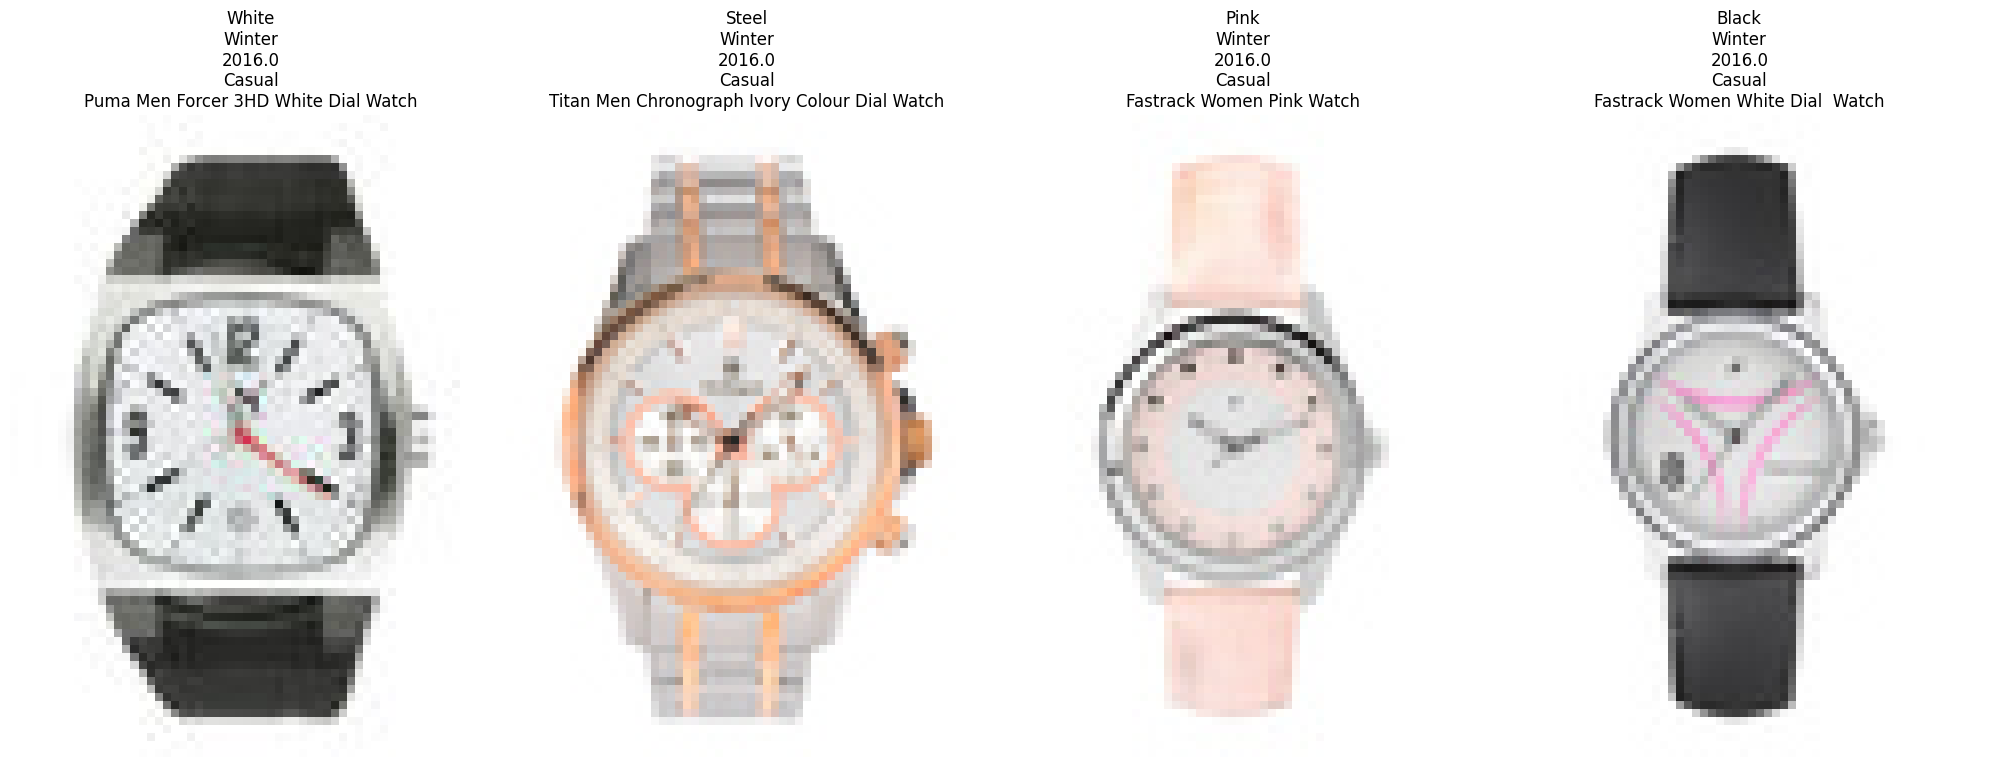

In [34]:
path_dict = {}
for path in Path('/teamspace/studios/this_studio/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

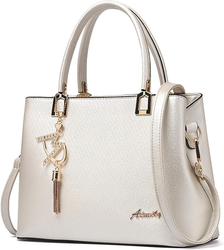

In [38]:
img_addr = 'https://m.media-amazon.com/images/I/61GpT8+nFXL._AC_UY900_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.LANCZOS)
img

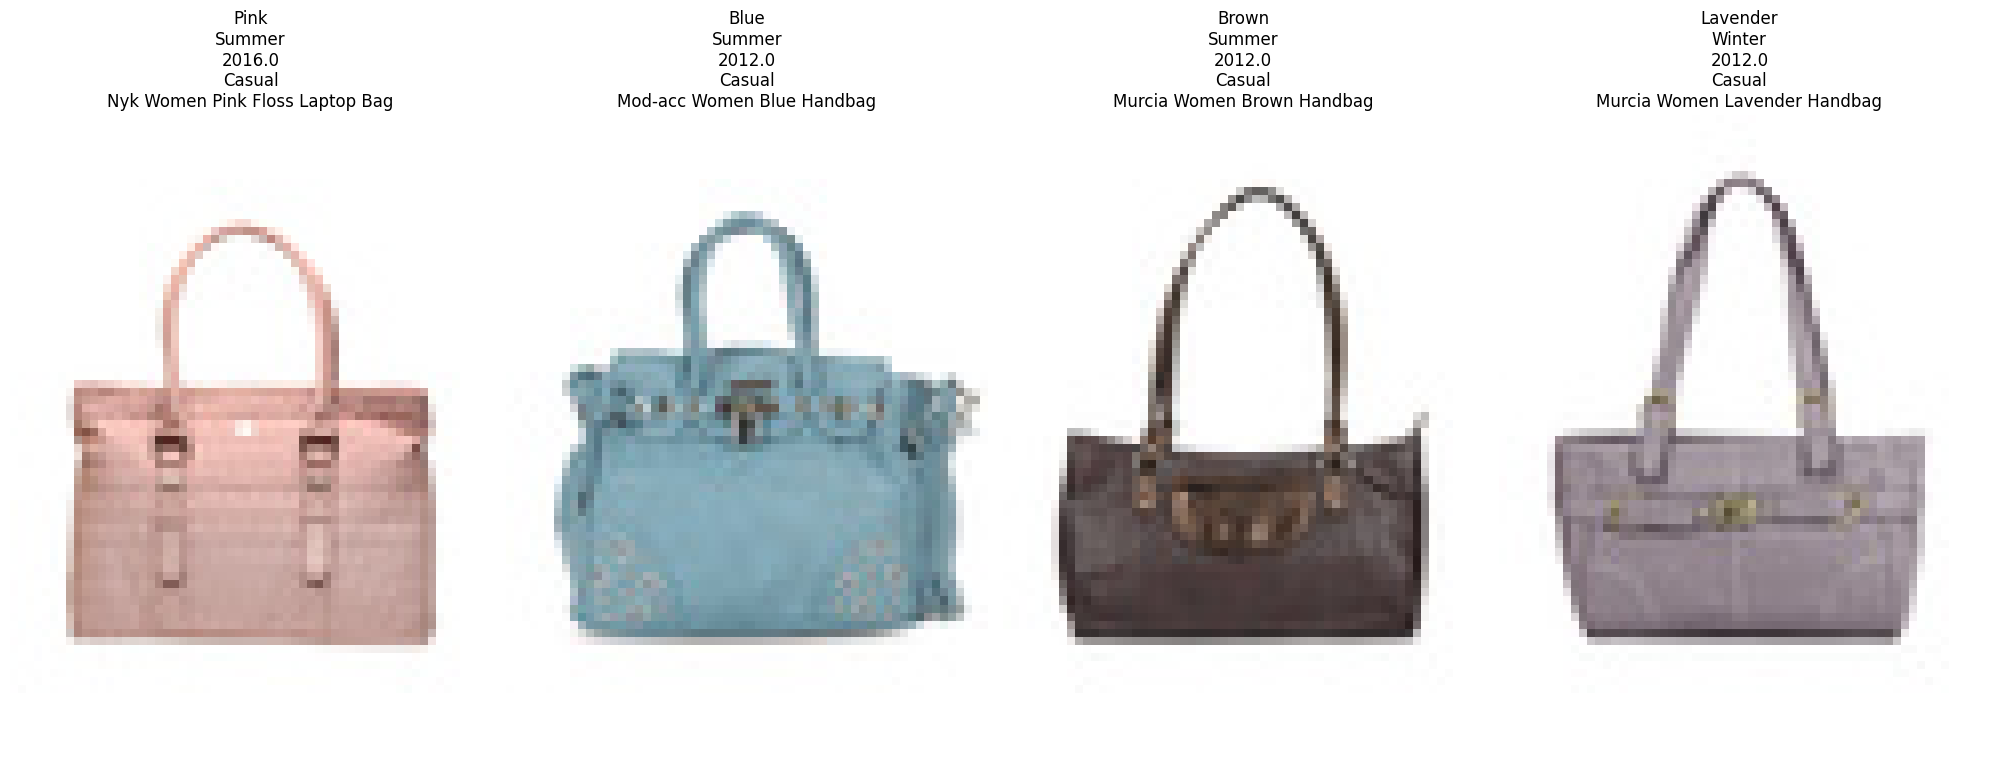

In [39]:
path_dict = {}
for path in Path('/teamspace/studios/this_studio/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()